# hyperoptによるパラメータチューニング

In [1]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, classification_report

from IPython.display import display

## データの準備

In [2]:
data_cancer_all = load_breast_cancer(as_frame=True)

data_cancer = data_cancer_all["data"]
target_cancer = data_cancer_all["target"]
frame_cancer = data_cancer_all["frame"]

print(data_cancer_all.keys())
display(data_cancer.head())
print(data_cancer.shape)
print(target_cancer.value_counts())

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


(569, 30)
1    357
0    212
Name: target, dtype: int64


In [3]:
display(frame_cancer.head())
display(frame_cancer.info())

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

None

## XGBoostのチューニング

In [4]:
import xgboost as xgb

In [5]:
from hyperopt import hp, tpe, Trials, fmin

#基本のパラメータ
XGB_PARAMS = {
    "booster":"gbtree"
    , "objective":"binary:logistic"
    , "eta":0.1
    , "max_depth":5
    , "colsample_bytree":0.8
    , "subsample":0.8
    , "gamma":0.0 
    , "lambda":1.0
    , "alpha":0.0
    , "min_child_weight":1
    , "eval_metric":"auc"
    , "random_state":43
}

#探索範囲
param_space = {
    "min_child_weight":hp.loguniform("min_child_weight", np.log(0.1), np.log(10))
    , "max_depth":hp.quniform("max_depth", 3, 4, 1)
    , "subsample":hp.quniform("subsample", 0.6, 0.95, 0.05)
    , "colsample_bytree":hp.quniform("colsample_bytree", 0.6, 0.95, 0.05)
    , "gamma":hp.loguniform("gamma", np.log(1e-8), np.log(1.0))
    #, "alpha":hp.loguniform("alpha", np.log(1e-8), np.log(1.0))
    #, "lambda":hp.loguniform("lambda", np.log(1e-8), np.log(1.0))
}


In [6]:
# 特徴量が多いので減らす
np.random.seed(43)
n_columns = len(data_cancer.columns)
print(n_columns)

n_feats = 5
idx_col = np.random.choice(range(n_columns), 5, replace=False)

feats = data_cancer.columns[idx_col]
print(feats)

30
Index(['worst compactness', 'perimeter error', 'area error', 'mean concavity',
       'mean concave points'],
      dtype='object')


In [8]:
train_x, test_x, train_y, test_y = train_test_split(data_cancer[feats], target_cancer, train_size=0.8, random_state=43)

xgb_train = xgb.DMatrix(train_x, train_y)
xgb_test = xgb.DMatrix(test_x, test_y)

In [9]:
def objective(args, seed=43):
    #ベースパラメータの取得
    xgb_params_search = XGB_PARAMS.copy()
    
    #探索パラメータの実行
    xgb_params_search.update(args)
    xgb_params_search["max_depth"] = int(xgb_params_search["max_depth"])
    

    #訓練と検証用に分割
    tr_x, va_x, tr_y, va_y = train_test_split(train_x, train_y, train_size=0.8, random_state=seed)

    #データの生成
    xgb_tr = xgb.DMatrix(tr_x, tr_y)
    xgb_va = xgb.DMatrix(va_x, va_y)

    xgb_clf = xgb.train(
            xgb_params_search
            , xgb_tr
            , num_boost_round=1000
            , evals = [(xgb_tr, "train"), (xgb_va, "valid")]
            , verbose_eval=0
            , early_stopping_rounds= 20
    )

    tr_pred = xgb_clf.predict(xgb_tr, ntree_limit=xgb_clf.best_ntree_limit)
    va_pred = xgb_clf.predict(xgb_va, ntree_limit=xgb_clf.best_ntree_limit)
    test_pred = xgb_clf.predict(xgb_test, ntree_limit=xgb_clf.best_ntree_limit)
    
    #auc 
    tr_auc = roc_auc_score(tr_y, tr_pred)
    va_auc = roc_auc_score(va_y, va_pred)
    test_auc= roc_auc_score(test_y, test_pred)
    
    return -1 * test_auc

In [10]:
# iterationする回数
max_evals = 100
# 試行の過程を記録するインスタンス
trials = Trials()

best = fmin(
    objective # 最小化する値を定義した関数
    , param_space # 探索するパラメータのdictもしくはlist
    , algo=tpe.suggest # どのロジックを利用するか、基本的にはtpe.suggestでok
    , max_evals=max_evals
    , trials=trials
    # 試行の過程を出力
    , verbose=1
)

100%|██████████| 100/100 [00:06<00:00, 16.40trial/s, best loss: -0.9863247863247864]


In [11]:
best

{'colsample_bytree': 0.9500000000000001,
 'gamma': 0.31380401530211594,
 'max_depth': 3.0,
 'min_child_weight': 0.9611658085570134,
 'subsample': 0.9}

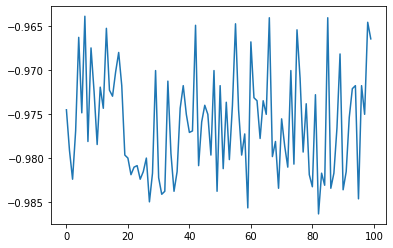

In [13]:
plt.plot(trials.losses())